# Mini Project Modul 4: Analisis & Segmentasi Pelanggan Telekomunikasi

## Langkah Awal: Menyiapkan Lingkungan dan Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, r2_score, mean_squared_error

In [2]:
# Mengunduh dataset dari sumber online
url = 'https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv'
df = pd.read_csv(url)

In [3]:
# --- Pra-pemrosesan Data Awal ---
# Mengubah TotalCharges menjadi numerik dan mengisi nilai kososng
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.dropna(subset=['TotalCharges'], inplace=True)

In [4]:
# Mengubah 'No internet service' menjadi 'No' untuk berapa kolom
for col in ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']:
    df[col] = df[col].replace({'No internet sevice': 'No'})

In [5]:
# Menampilkan beberapa baris pertama dari data
print("Data berhasil dimuat. Berikut adalah 5 baris pertama:")
print(df.head())

Data berhasil dimuat. Berikut adalah 5 baris pertama:
   customerID  gender  SeniorCitizen  ... MonthlyCharges TotalCharges  Churn
0  7590-VHVEG  Female              0  ...          29.85        29.85     No
1  5575-GNVDE    Male              0  ...          56.95      1889.50     No
2  3668-QPYBK    Male              0  ...          53.85       108.15    Yes
3  7795-CFOCW    Male              0  ...          42.30      1840.75     No
4  9237-HQITU  Female              0  ...          70.70       151.65    Yes

[5 rows x 21 columns]


## Bagian 1: Segmentasi Pelanggan dengan K-Means (Clustering)

In [6]:
# --- Clustering ---
# Memilih fitur untuk clustering
features_for_clustering = df[['tenure', 'MonthlyCharges']]

In [7]:
# Menskalakan fitur agar memiliki skala yang sama
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features_for_clustering)

In [8]:
# Membuat dan melatih model K-Means dengan 4 cluster
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(scaled_features)

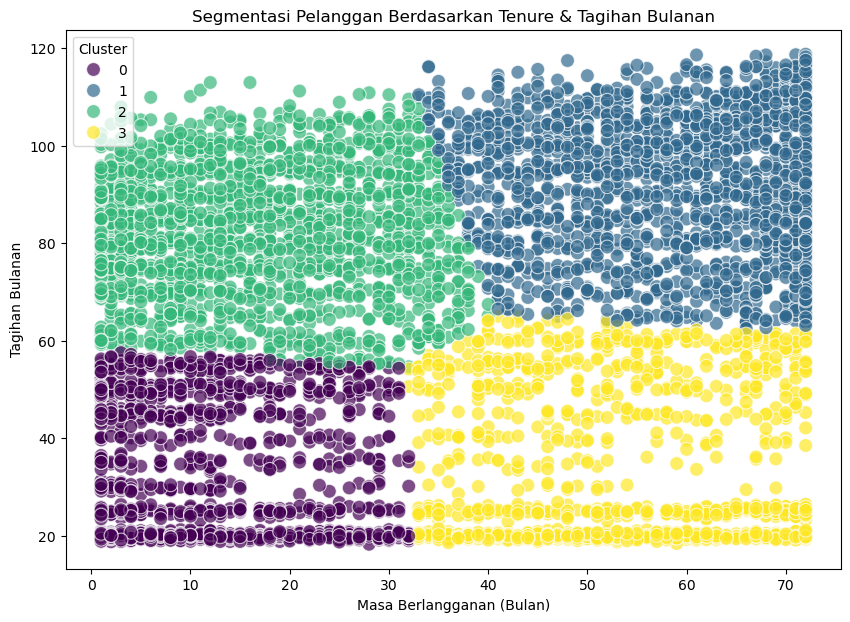

In [9]:
# Visualisasi hasil clustering
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df, x='tenure', y='MonthlyCharges', hue='Cluster', palette='viridis', s=100, alpha=0.7)
plt.title('Segmentasi Pelanggan Berdasarkan Tenure & Tagihan Bulanan')
plt.xlabel('Masa Berlangganan (Bulan)')
plt.ylabel('Tagihan Bulanan')
plt.legend(title='Cluster')
plt.show()

In [10]:
# Analisis singkat cluster
print("\nRata-rata untuk setiap cluster:")
print(df.groupby('Cluster')[['tenure', 'MonthlyCharges']].mean())


Rata-rata untuk setiap cluster:
            tenure  MonthlyCharges
Cluster                           
0        10.536543       32.482454
1        58.738351       93.013108
2        14.820909       81.228841
3        54.115152       34.028745


**Interpretasi:**

Dari perhitungan tersebut, berhasil ditemukan **4 grup pelanggan yang jelas berbeda**:
- **Pelanggan Baru, Nilai Rendah**: Baru berlangganan, tagihan murah
- **Pelanggan Premium/Loyal**: Sudah lama berlangganan, tagihan mahal.
- **Pelanggan Baru, Nilai Tinggi**: Baru berlangganan, tagihan mahal (potensial tapi beresiko).
- **Pelanggan Lama, Nilai Rendah**: Sudah lama berlangganan, tagihan murah.

## Bagian 2: Memprediksi Churn dengan Regresi Logistik (Klasifikasi)

In [11]:
# --- Klasifikasi (Prediksi Churn) ---
# Mendefinisikan fitur (X) dan target (Y)
X = df.drop(['customerID', 'Churn'], axis=1)
Y = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0) # Mengubah Yes/No menjadi 1/0

In [12]:
# Memisahkan kolom numerik dan kategorikal
numeric_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(exclude=np.number).columns.tolist()

In [13]:
# Membuat pipeline untuk pra-premosesan
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

In [14]:
# Membuat pipeline lengkap dengan model Regresi Logistik
classification_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                          ('classifier', LogisticRegression(random_state=42))])

In [15]:
# Membagi data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [16]:
# Melatih moodel
classification_pipeline.fit(X_train, Y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['SeniorCitizen', 'tenure',
                                                   'MonthlyCharges',
                                                   'TotalCharges', 'Cluster']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['gender', 'Partner',
                                                   'Dependents', 'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod'])])),
                ('classifier', LogisticRegression(random_state=42))])

In [17]:
# Membuat prediksi
Y_pred = classification_pipeline.predict(X_test)

In [18]:
# Mengevaluasi model
print("\n--- Hasil Model Prediksi Churn ---")
print("Confusion Matrix:\n", confusion_matrix(Y_test, Y_pred))
print(f"\nAccuracy: {accuracy_score(Y_test, Y_pred):.2f}")
print(f"\nPrecission: {precision_score(Y_test, Y_pred):.2f}")
print(f"\nRecall: {recall_score(Y_test, Y_pred):.2f}")


--- Hasil Model Prediksi Churn ---
Confusion Matrix:
 [[915 118]
 [181 193]]

Accuracy: 0.79

Precission: 0.62

Recall: 0.52


**Interpretasi:**

Model tersebut **cukup akurat (79%)** secara keseluruhan. Namun, model ini **melewatkan hampir setengah (48%)** dari pelanggan yang sebenarnya akan berhenti berlangganan. Hal tersebut adalah area utama yang perlu ditingkatkan.

## Bagian 3: Memprediksi Total Tagihan dengan Regresi Linear

In [19]:
# --- Regresi (Prediksi TotalCharges) ---
# Mendefinisikan fitur (X) dan target (Y)
X_reg = df[['tenure', 'MonthlyCharges']]
Y_reg = df['TotalCharges']

In [20]:
# Membuat dan melatih model Regresi Linear
regression_model = LinearRegression()
regression_model.fit(X_reg, Y_reg)

LinearRegression()

In [21]:
# Membuat prediksi pada data yang ada untuk evaluasi
Y_reg_pred = regression_model.predict(X_reg)

In [22]:
# Mengevaluasi model
r2 = r2_score(Y_reg, Y_reg_pred)
rmse = np.sqrt(mean_squared_error(Y_reg, Y_reg_pred))

In [23]:
print("\n--- Hasil Model Prediksi Total Tagihan ---")
print(f"R-squared (R2): {r2:.4f}")
print(f"Root Mean Squared Error (RMSE): ${rmse:.2f}")


--- Hasil Model Prediksi Total Tagihan ---
R-squared (R2): 0.8950
Root Mean Squared Error (RMSE): $734.35


In [25]:
# Contoh prediksi baru
contoh_pelanggan = [[70, 100]] # Pelanggan dengan tenure 70 bula, tagihan bulanan $100
prediksi_total_tagihan = regression_model.predict(contoh_pelanggan)
print(f"\nPrediksi Total Tagihan untuk pelanggan baru: ${prediksi_total_tagihan[0]:.2f}")


Prediksi Total Tagihan untuk pelanggan baru: $6004.45


c:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


**Interpretasi:**

Model ini **sangat bagus (R2: 89.5%)**. prediksinya sangat mendekati nilai asli, sehingga sangat berguna untuk memperkirakan pendapatan dari pelanggan di masa depan.